### The purpose of this notebook is to explain the process of creating surface profiles. For hubble images these will be surface brightness profiles. For the ALMA moments maps this would be Flux density profiles. 

First it is important to generate a test case that we can use to test our functions against. In order to do this we generate some 2d emission using a sersic profile which we will have to recover later. 

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from astropy.modeling import models

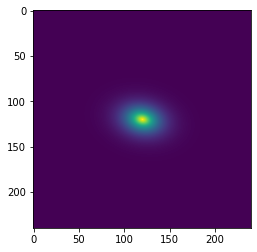

In [12]:
NUMBER_OF_ROWS = 240
NUMBER_OF_COLUMNS = 240

y, x = np.mgrid[:NUMBER_OF_ROWS, :NUMBER_OF_COLUMNS]

sersic_model = models.Sersic2D(amplitude=1, r_eff = 20, n=0.8, x_0=0.5*NUMBER_OF_COLUMNS, y_0 = 0.5*NUMBER_OF_ROWS, ellip=0.3, theta=0.2)
image = sersic_model(x,y)
plt.imshow(image)

### Uncertainties

#### Propogation of log error


\begin{align*}
f & = a\log_{10}\left(bA\right) \\
\Rightarrow u(f) & \approx a\frac{u(A)}{A \ln\left(10\right)}  
\end{align*}

therefore:
\begin{align*}
\text{ST}_{\rm mag} & = -2.5 \log\left(F_{\lambda}\right) -21.1 \\
u(\text{ST}_{\rm mag}) & \approx 2.5 \frac{u(F_{\lambda})}{F_{\lambda} \ln\left(10\right)}
\end{align*}

Taking an "average flux": $\bar{F_{\lambda}}  = \frac{F_{\lambda}}{A}$ where $A$ is the area of the region. We get:

\begin{align*}
u\left(\bar{\text{ST}_{\rm mag}}\right)  & \approx 2.5\frac{u\left(\frac{F_{\lambda}}{A}\right)}{\frac{F_{\lambda}}{A}} \\
& \approx 2.5 \frac{\frac{u(F_{\lambda})}{A}}{\frac{F_{\lambda}}{A} \ln\left(10\right)} \\
& \approx 2.5 \left(\frac{u(F_{\lambda})}{A} \frac{A}{F_{\lambda} \ln\left(10\right)}\right) \\
& \approx 2.5 \frac{u\left(F_{\lambda}\right)}{F_{\lambda} \ln\left(10\right)} \\
& = u\left(\text{ST}_{\rm mag}\right)
\end{align*}


Therefore the uncertainty associated with the magnitude is the same as the uncertainty of the surface brightness so long as the uncertainty of the area is 0. This is to be expected since the $b$ variable in the first equation is not present in the uncertainty calculation.

## Working out the uncertainty of an aperture
In order to work out the uncertainty of an aperture we need to consider the uncertainty of any given pixel $p_i$. Each pixel has a value which would be determined as the measured photons minus the background emission. This means that the uncertainty of ever pixel would be:
\begin{equation*}
u(\rm pix) = \sqrt{u(\gamma)^2 + u(\rm \beta)^2}
\end{equation*}

I.e. uncertainty of a pixel is made up of 1) the background noise, which is simply the rms and 2) the poisson uncertainty associated with counting. The poisson noise is straight forward as is equal to the $\sqrt{p_i}$ where $p_i$ is the value of the pixel. Thus, 


\begin{align*}
u(\rm reg) &= \sqrt{u(\rm pix_1)^2 + u(\rm pix_2)^2 + \cdots + u(\rm pix_{n-1})^2 + u(\rm pix_{n})^2} \\
&= \sqrt{\sum\limits_{i=1}^n u(\rm pix_i)^2} \\
&= \sqrt{\sum\limits_{i=1}^n \left(\sqrt{u(\gamma_i)^2 + u(\beta_i)^2}\right)^2} \\
&= \sqrt{\sum\limits_{i=1}^n \left(u(\gamma_i)^2 + u(\rm \beta_i)^2\right)} \\
&= \sqrt{\sum\limits_{i=1}^n u(\gamma_i)^2 + \sum\limits_{i=1}^n u(\beta_i)^2} \\
&= \sqrt{\sum\limits_{i=1}^n \sqrt{\gamma_i}^2 + \sum\limits_{i=1}^n \sigma^2} \\
&= \sqrt{\sum\limits_{i=1}^n \gamma_i + \sum\limits_{i=1}^n \sigma^2} \\
&= \sqrt{F_{\rm sum, reg} + \sigma^2n}
\end{align*}


